In [1]:
# from IPython import display
import requests
from lxml import html
from lxml.etree import XPathEvalError
import pandas as pd
from configparser import ConfigParser

config = ConfigParser('config.ini')
email = config['login']['email']
password = config['login']['password']

pd.set_option('display.max_rows', 100)

df = pd.DataFrame()

url = 'https://profitus.lt/users/login'

resp = ''

with requests.session() as client:
  client.get(url)
  csrftoken = client.cookies['csrfToken']
  login_data = dict(email=email, password=password, _csrfToken=csrftoken, next='/')
  r = client.post(url, data=login_data, headers=dict(Referer=url))
  resp = client.get('https://www.profitus.lt/secondary-market') # ?page=5
  tree = html.fromstring(resp.text)
  next_url = 'https://profitus.lt' + tree.xpath('//a[@class="page-link-p fw-700"]')[0].values()[0]

  df = pd.read_html(resp.text)[0]
  try:
    while next_url:
      b = 2
      resp = client.get(next_url)
      print(resp.url)
      tree = html.fromstring(resp.text)
      next_url = 'https://profitus.lt' + tree.xpath('//a[@class="page-link-p fw-700"]')[b].values()[0]
      # df.merge(pd.read_html(resp.text)[0])
      df = pd.concat((df, pd.read_html(resp.text)[0]))
      if len(tree.xpath('//a[@class="page-link-p fw-700"]')) == 4:
        b = 2
      else:
        raise XPathEvalError('XPath was not found | scraping ended.')
  except (XPathEvalError, IndexError):
      print('scraping is over!')
  # print(df.columns)
df = df.drop(['Unnamed: 0', 'Unnamed: 9'], axis=1)

df['Projekto pavadinimas'] = df['Projekto pavadinimas'].map(lambda x: x.lstrip('Projekto pavadinimas:&nbsp '))
df['Reitingas'] = df['Reitingas'].map(lambda x: x.lstrip('Reitingas:&nbsp '))
df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.lstrip('Likęs terminas:&nbsp ').rstrip('mėn.'))

df['Likęs terminas'] = df['Likęs terminas'].map(lambda x: x.split('/')[0]).astype(int) + 1 # 1 month and 29 days is considered as 1 month, we're calculating worst example possible. only those will be worth to buy


df['Likusi suma'] = df['Likusi suma'].map(lambda x: x.lstrip('Likusi suma:&nbsp'))

df['Likusi suma'] = df['Likusi suma'].str.replace('€', '')
df['Likusi suma'] = df['Likusi suma'].str.replace(',', '').astype(float)

df['Palūkanų norma'] = df['Palūkanų norma'].map(lambda x: x.lstrip('Palūkanų norma:&nbsp'))

df['Palūkanų norma'] = df['Palūkanų norma'].str.replace('%', '').astype(float)


df['Statusas'] = df['Statusas'].map(lambda x: x.lstrip('Statusas:&nbsp'))

df['Statusas'] = df['Statusas'].str.replace('Aktyvus', '1')
df['Statusas'] = df['Statusas'].str.replace('Vėluoja', '2').astype(int)



df['Likusi gautina sumai'] = df['Likusi gautina sumai'].map(lambda x: x.lstrip('Likusi gautina suma:&nbsp '))

df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace('€', '')
df['Likusi gautina sumai'] = df['Likusi gautina sumai'].str.replace(',', '').astype(float)

df['Pardavimo kaina'] = df['Pardavimo kaina'].map(lambda x: x.lstrip('Pardavimo kaina:&nbsp '))

df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace('€', '')
df['Pardavimo kaina'] = df['Pardavimo kaina'].str.replace(',', '').astype(float)

df['Realios palūkanos'] = (df['Likusi gautina sumai'] - df['Pardavimo kaina']) * 100 / df['Pardavimo kaina'] / (df['Likęs terminas']/12)
print(df[(df['Palūkanų norma'] - df['Realios palūkanos']) < 0]) # basically we're trying to find projects that have largest interest rate, than
df.sort_values('Realios palūkanos', ascending=False).head(100)

https://profitus.lt/secondary-market?page=2
https://profitus.lt/secondary-market?page=3
https://profitus.lt/secondary-market?page=4
https://profitus.lt/secondary-market?page=5
https://profitus.lt/secondary-market?page=6
https://profitus.lt/secondary-market?page=7
https://profitus.lt/secondary-market?page=8
scraping is over!
Empty DataFrame
Columns: [Projekto pavadinimas, Reitingas, Likęs terminas, Likusi suma, Palūkanų norma, Statusas, Likusi gautina sumai, Pardavimo kaina, Realios palūkanos]
Index: []


,Projekto pavadinimas,Reitingas,Likęs terminas,Likusi suma,Palūkanų norma,Statusas,Likusi gautina sumai,Pardavimo kaina,Realios palūkanos
2,#332 Palėpės rekonstrukcija Kauno centre III,B-,7,500.00,8.5,1,530.74,511.0,6.622309
2,#411 Antakalnio vakarai,D,12,570.25,12.0,1,638.31,610.0,4.640984
3,#274 Namas Kulmo g.,B-,8,1500.00,9.0,1,1593.58,1550.0,4.217419
1,#354 Apartamentai senamiestyje,B,9,100.00,7.0,1,105.14,102.0,4.104575
0,#363 Butas Žirmūnuose,B,9,100.00,7.0,1,105.10,102.0,4.052288
0,#411 Antakalnio vakarai,D,12,6050.00,13.0,1,6832.19,6580.0,3.832675
5,#315 8 butas Pažaislio apartamentuose,B,5,330.22,7.0,1,340.16,335.0,3.696716
1,#411 Antakalnio vakarai,D,12,500.00,12.0,1,559.67,540.0,3.642593
1,#395 Saurenta plėtra,C+,11,100.00,8.5,1,108.45,105.0,3.584416
2,#398 Poilsio namai „Mežliči“ II,C-,11,104.16,8.0,1,112.45,109.0,3.452877


In [5]:
print(df[(df['Palūkanų norma'] - df['Realios palūkanos']) < 0]) # basically we're trying to find projects that have largest interest rate, than


Empty DataFrame
Columns: [Projekto pavadinimas, Reitingas, Likęs terminas, Likusi suma, Palūkanų norma, Statusas, Likusi gautina sumai, Pardavimo kaina, Realios palūkanos]
Index: []


In [4]:
df[df['Realios palūkanos'] < 0]

,Projekto pavadinimas,Reitingas,Likęs terminas,Likusi suma,Palūkanų norma,Statusas,Likusi gautina sumai,Pardavimo kaina,Realios palūkanos
3,#337 Valakampių apartamentai,C+,8,100.0,8.0,2,105.59,115.0,-12.273913
4,#322 Namas Žemuogių g.,C,6,110.0,8.5,2,114.33,115.0,-1.165217
1,"#343 Namų kvartalas „Baltai sala""",C-,8,350.0,9.0,1,373.04,375.0,-0.784000
3,#400 Du dvibučiai Didžiojoje Riešėje II,C+,11,500.0,8.0,1,539.78,544.0,-0.846257
1,#394 Mėtų dvibutis,C,5,100.0,8.5,1,104.19,105.0,-1.851429


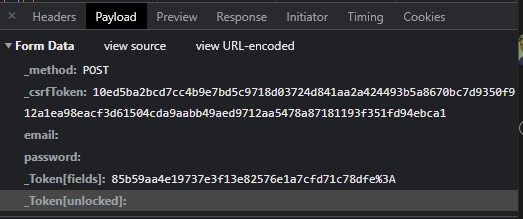


In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')

df.sort_values('Realios palūkanos', ascending=False).head(100).to_excel(f'profitus_secondary_market_{date}.xlsx')